In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn

# **Dataset**

We will use the HuggingFace library to download the dataset named "imdb". 

The dataset contains the movie reviews and the respective label informing about its sentiment: positive or negaive.


In [2]:
from datasets import load_dataset
dados_imdb = load_dataset('imdb')

Found cached dataset imdb (/Users/miguelwon/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
#Let's see the dataset structure
dados_imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Exercise 2: Ok, now print the first three examples of the train dataset

In [4]:
for i in range(3):
    print(dados_imdb['train'][i])

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

# Tokenization 

A very important step when wokring with sequence models, is the tokenization. This step is responsible for split the text into tokens, where each token is the sequence unit that will be used by the model. It can be a word, a character, a subword, etc, depending on the tokenization method.

In this case, we will use a traditional tokenization method: word tokenization. For this method we want to spli the text into words. We will use word_tokenizer from the nltk library.


In [5]:
from nltk.tokenize import word_tokenize
from string import punctuation
def contains_punctuation(text):
    return any(c in punctuation for c in text)
        
def tokenize(text):
    return [tk.lower() for tk in word_tokenize(text) if not contains_punctuation(tk)]

test = dados_imdb['train'][0]['text']
tokens = tokenize(test)
print(tokens)

['i', 'rented', 'i', 'am', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'br', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues', 'in', 'the', 'united', 'states', 'in', 'between', 'askin

# Vocabulary

After tokenization, we will create a vocabulary, which is a dictionary that maps each token to an index. 
The vocabulary is necessary because the model will train with a closed set of tokens. So, we need to create a vocabulary with all the tokens that we want to use in the model. 

Furthermore, when building this vocabulary we will also map tokens to numbers. This is important because the model will work with numbers, not with words. So, we need to map each token to a number.

We will build the vocabulary using the train dataset only. For that we will first count the frequency of each token in the train dataset. 

In [7]:
from collections import defaultdict, Counter

vocab_count = defaultdict(int)
for review in dados_imdb['train']:
    for tk in tokenize(review['text']):
        vocab_count[tk] += 1
print("Lenght of vocabulary:", len(vocab_count))

Lenght of vocabulary: 73119


73k is a big vocabulary. Let's apply a filter to remove the less frequent tokens. 

We can do this because the less frequent tokens are usually typos or names that are not relevant to the model.

Let's filter the vocabulary to remove the tokens present less than 5 times in the train dataset.

In [8]:
min_freq = 10
filtered_vocab = [t for t, c in vocab_count.items() if c >= min_freq]
print("Lenght of filtered vocabulary:", len(filtered_vocab))

Lenght of filtered vocabulary: 19581


So this is a more reasonable vocabulary size.

Now we can build the vocabulary dictionary that maps each word to a unique integer (it equivalent to its ID)

Note that will start at 1, not 0. This is because we will use 0 for padding.

In [9]:
filtered_vocab = ['<pad>','<sos>','<eos>'] + filtered_vocab

In [10]:
filtered_vocab[:10]

['<pad>',
 '<sos>',
 '<eos>',
 'i',
 'rented',
 'am',
 'from',
 'my',
 'video',
 'store']

In [11]:
tok2id = {}
id2tok = {}
for i,palavra in enumerate(filtered_vocab):
    tok2id[palavra] = i
    id2tok[i] = palavra

Now that we have the vocabulary dictionary, we can use it to convert the tweets to sequences of integers.

Also, we can create a list with the encoded labels 

In [12]:
train_token_ids = []
train_labels = []
for review in tqdm(dados_imdb['train']):
    texto = review['text']
    tokens = tokenize(texto)
    tokens_ids = [tok2id[tk] for tk in tokens if tk in tok2id]
    train_token_ids.append(tokens_ids)
    train_labels.append(review['label'])

100%|██████████| 25000/25000 [00:19<00:00, 1305.69it/s]


In [13]:
print([id2tok[tk_id] for tk_id in train_token_ids[0]])

['i', 'rented', 'i', 'am', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'br', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam', 'war', 'and', 'race', 'issues', 'in', 'the', 'united', 'states', 'in', 'between', 'asking', 'poli

We need to truncate and pad the sequences to the same lenght. 
First, we check the distribution of the sequence lenghts. Then, we choose a maximum lenght that will be used to truncate and pad the sequences.

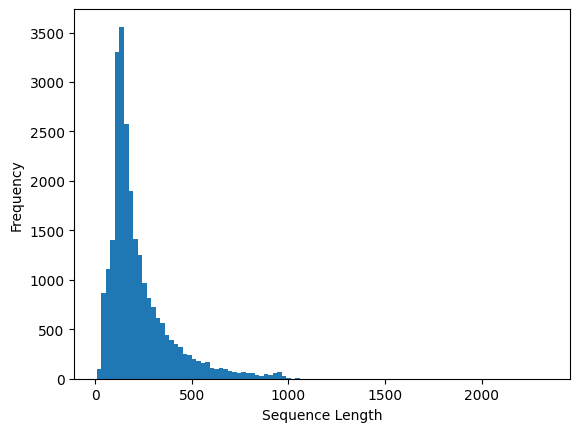

In [15]:
import matplotlib.pyplot as plt


# Define a list of sequence lengths
lengths = [len(seq) for seq in train_token_ids]
# Create a histogram
plt.hist(lengths, bins=100)
# Add labels
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
# Show the plot
plt.show()

OK, let's pad to a maximum of 500 tokens. Is likely that the sentiment is at the beginning of the sequence.

In [16]:
# We not apply the padding to the sequences, so that all sequences have the same length.
# If the sequence is higher than the max_length, we truncate it. If it is smaller, we pad it with 0.

def pad_sequence(seq, max_length = 500):
    return seq[:max_length] if len(seq) > max_length else [0] * (max_length - len(seq)) + seq

train_token_ids = [pad_sequence(seq) for seq in train_token_ids]

# Dataset and Dataloader

We now need to create a dataloader that will us to iterate over batches, during the training process. For that we will use the dataset class from the HuuggingFace datasets library that allows to easily create a dataset from a list of examples.

In [17]:
from torch.utils.data import DataLoader
from datasets import Dataset

In [19]:
from torch.utils.data import DataLoader
from datasets import Dataset

list_data = [{'review':train_token_ids[i],'label':train_labels[i]} for i in range(len(train_token_ids))]
train_dataset = Dataset.from_list(list_data)
train_dataset = train_dataset.with_format("torch")

batch_size = 32 # number of sequences in each batch
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size) # train_dataloader is an iterator that returns a batch each time it is called

# Repeat the same process for the test dataset

Ok, so now we are going repeat the same process but for the test dataset but using the vocabulary that we created with the train dataset.

In [20]:
# tokenize, encode to ids and pad the sequences
test_token_ids = []
test_labels = []
for review in tqdm(dados_imdb['test']):
    texto = review['text']
    tokens = tokenize(texto)
    tokens_ids = [tok2id[tk] for tk in tokens if tk in tok2id]
    test_token_ids.append(tokens_ids)
    test_labels.append(review['label'])

100%|██████████| 25000/25000 [00:18<00:00, 1329.05it/s]


In [21]:
test_token_ids = [pad_sequence(seq) for seq in test_token_ids]

In [22]:
# create the test dataset and dataloader
list_data = [{'review':test_token_ids[i],'label':test_labels[i]} for i in range(len(test_token_ids))]
test_dataset = Dataset.from_list(list_data)
test_dataset = test_dataset.with_format("torch")
batch_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=batch_size) 

# One-hot vs Embedding

When working with sequence models, we need to convert the tokens to numbers. There are two main ways to do this: one-hot encoding or embedding (dense representation).

In one-hot representation, each token is represented by a vector with the size of the vocabulary. This vector is filled with zeros, except for the index that corresponds to the token, which is filled with one. For example:

* Vocabulary: {I, love, cats}
* One-hot representation of "I": [1, 0, 0]
* One-hot representation of "love": [0, 1, 0]
* One-hot representation of "cats": [0, 0, 1]

On problem of this representation is that it is very sparse, since most of the vector is filled with zeros. So, it is not very efficient.
Also, this representation does not capture the semantic of the tokens. For example, one-hot representation 
of semantically similar tokens are orthogonal vectors, which means that they are not similar at all.

In embedding representation, each token is represented by a dense vector with a fixed size. This vector is filled with numbers, which are learned during the training process. For example:

* Embedding representation of "I": [0.1, 0.2, 0.3]
* Embedding representation of "love": [0.4, 0.5, 0.6]
* Embedding representation of "cats": [0.7, 0.8, 0.9]

This representation is more efficient than one-hot representation, since it is not sparse. This means that we can represent each 
token by a vector with a smaller size. Also, this representation will allow to build vector that encode the semantic of the tokens, resulting in similar vectors for semantically similar tokens. Furthermore, the use of dense vectors will allow better and smoother training process, because the gradients will be more stable.

We will use torch embedding layer to deal with the embedding representation.

There are two ways to create an embedding layer: with random weights or with pre-trained weights.

In case of random weights, the embedding layer will be trained during the training process. In case of pre-trained weights, the embedding layer will be initialized with pre-trained weights and then two options are possible: the weights will be frozen during the training process or we can choose to train the embedding layer as well. 


Is very simple to create an embedding layer with random weitghts:

In [23]:
# Embdding layer of 3 dimension and with a vobulary of size 10
embedding_layer = nn.Embedding(10, 7) 
embedding_layer.weight

Parameter containing:
tensor([[-0.2490, -0.8219,  1.3262, -1.4039, -2.1352,  0.1941,  1.4937],
        [ 0.5579, -0.2237,  1.2445,  0.0413, -0.9851, -1.2416,  0.0062],
        [ 0.6102, -1.8001,  1.0985, -1.4031,  0.1936,  0.6545,  0.9164],
        [-1.1998,  1.8247,  0.0066, -0.2990, -0.7800,  0.5601, -1.4515],
        [-0.1557, -0.6846, -0.7219, -0.3413, -1.4996, -0.1387,  1.6648],
        [-0.6571, -0.2279,  0.3645, -0.6872, -0.5007, -0.1122,  0.1135],
        [-0.9880, -0.6142,  0.1248, -0.1842,  0.6028, -0.5164,  1.1818],
        [ 0.1518,  1.1230,  0.0647, -0.6336,  0.8869,  1.1192, -1.0769],
        [-0.5130, -1.9409, -1.4984,  0.3284,  0.3447,  0.1116,  1.0883],
        [-1.2491, -1.9218, -0.2032,  0.1040,  1.9599,  1.0225,  1.0087]],
       requires_grad=True)

# RNN layer 

Pytorch has a RNN layer that can be used to build a RNN model. We will use the following parameters:

* input_size: the size of the input vector. In our case, it is the size of the embedding vector.
* hidden_size: the size of the hidden vector. This is the size of the output vector of the RNN layer.
* batch_first: if True, the input and output tensors will have the shape (batch_size, seq_len, hidden_size). Otherwise, the shape will be (seq_len, batch_size, hidden_size).

Let's an example of a RNN layer that receives as input the embedding we just created:

In [24]:
rnn_layer = nn.RNN(
        7,  # dimension of the input. It is the same as the embedding dimension
        5,  # dimension of the hidden state
        batch_first=True) # if the input and output tensors are provided as (batch, seq, feature)

Now lets suppose we have the sequence of tokens  [4,2,3,9]
We first look up the embedding for each token:

In [25]:
embedding_seq = embedding_layer(torch.IntTensor([4,2,3,9]))
embedding_seq

tensor([[-0.1557, -0.6846, -0.7219, -0.3413, -1.4996, -0.1387,  1.6648],
        [ 0.6102, -1.8001,  1.0985, -1.4031,  0.1936,  0.6545,  0.9164],
        [-1.1998,  1.8247,  0.0066, -0.2990, -0.7800,  0.5601, -1.4515],
        [-1.2491, -1.9218, -0.2032,  0.1040,  1.9599,  1.0225,  1.0087]],
       grad_fn=<EmbeddingBackward0>)

And then we can feed the embedding to the RNN layer:

In [26]:
out, hidden = rnn_layer(embedding_seq)
print("out:")
print(out)
print("")
print("hidden:")
print(hidden)

out:
tensor([[-0.3708, -0.1232, -0.2305, -0.6924,  0.8073],
        [-0.0552,  0.6245, -0.7801, -0.1343, -0.0075],
        [-0.7834, -0.6678,  0.1214, -0.6272,  0.0161],
        [ 0.7272,  0.6300, -0.6650,  0.4390, -0.3755]],
       grad_fn=<SqueezeBackward1>)

hidden:
tensor([[ 0.7272,  0.6300, -0.6650,  0.4390, -0.3755]],
       grad_fn=<SqueezeBackward1>)


Note that the hidden vector is the output of the RNN layer for the last token of the sequence.

Let's now build the main RNN model. 

In [27]:
# The main class of the RNN built from the nn.Module class
class SentRNN(nn.Module):

    def __init__(self, vocab_size, output_size, emb_d,hidden_d,n_layers, drop_prob = 0.5, lstm = False):
        """
        Initialize the RNN Module

        Arguments:
        vocab_size: size of the vocabulary
        output_size: size of the output layer
        emb_d: size of the embedding layer
        h_d: size of the hidden layer
        n_layers: number of layers
        drop_prob: dropout probability
        """
    
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_d = hidden_d

        # define the embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_d)

        # define a RNN layer
        if lstm:
            self.rnn = nn.LSTM(emb_d, hidden_d, n_layers, dropout = drop_prob, batch_first=True) # batch_first=True means that the first dimension of the input and output will be the batch_size
        else:
            self.rnn = nn.RNN(emb_d, hidden_d, n_layers, dropout = drop_prob, batch_first=True)

        # define a dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # define a fully-connected layer
        self.fc = nn.Linear(hidden_d, output_size)

        # We use sigmoid activation function because we want to predict a probability between 0 and 1
        # In case of more than 2 classes, we would use softmax
        self.sigmoid = nn.Sigmoid()         

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.

        Arguments:
        x: input to the model
        hidden: hidden state

        Returns:
        output: output of the model
        hidden: hidden state
        """

        # define batch size
        # batch_size = x.size(0)

        # embeddings 
        embeds = self.embedding(x)
        out, _ = self.rnn(embeds)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out


We now can instantiate the main model 

In [28]:
review_token_ids = []
review_labels = []
for review in tqdm(dados_imdb['train']):
    texto = review['text']
    tokens = tokenize(texto)
    tokens_ids = [tok2id[tk] for tk in tokens if tk in tok2id]
    review_token_ids.append(tokens_ids)
    review_labels.append(review['label'])

100%|██████████| 25000/25000 [00:19<00:00, 1298.41it/s]


In [31]:
vocab_size = len(tok2id) 
output_size = 1
embedding_dim = 50
hidden_dim = 32
n_layers = 1
device = "mps"

model = SentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
model

/Users/miguelwon/opt/miniconda3/envs/ml-pt-2/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


SentRNN(
  (embedding): Embedding(19584, 50)
  (rnn): RNN(50, 32, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# Training

Ok we are now ready to train the model. We will use the Adam optimizer and the BCELoss loss because we are dealing with a binary classification problem.

In [32]:
# main training loop
n_epochs = 4
lr=1e-3
clip = 1
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

step = 0
evaluation_step = 500
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    loss_train_total = 0
    for i, batch in enumerate(train_dataloader):
        step += 1
        inputs = batch['review'].to(device)
        labels = batch['label'].to(device)

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        output = model(inputs)
        # calculate the loss
        loss = criterion(output.squeeze(), labels.float())
        loss_train_total += loss.item()
        # backward pass
        loss.backward()

        # clip the gradients to prevent exploding gradient problem. This step is very important.
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update the parameters
        optimizer.step()

        # evaluation step
        if step % evaluation_step == 0:
            model.eval()
            with torch.no_grad():
                # evaluate on training data
                loss_val = 0
                for j,batch in enumerate(test_dataloader):
                    inputs = batch['review'].to(device)
                    labels = batch['label'].to(device)

                    output = model(inputs)
                    loss = criterion(output.squeeze(), labels.float())
                    loss_val += loss.item()
            model.train()
            # print the loss at each step 
            print(f'Epochs: {epoch + 1} | Step: {step} | Train Loss: {loss_train_total/i: .3f} | Val Loss: {loss_val/j: .3f}' )
            
            train_losses.append(loss_train_total/i)
            val_losses.append(loss_val/j)
    # print(f'Epochs: {epoch + 1} | Train Loss: {loss_train_total/i: .3f} | Val Loss: {loss_val/j: .3f}' )

Epochs: 1 | Step: 500 | Train Loss:  0.699 | Val Loss:  0.686
Epochs: 2 | Step: 1000 | Train Loss:  0.645 | Val Loss:  0.633
Epochs: 2 | Step: 1500 | Train Loss:  0.619 | Val Loss:  0.587
Epochs: 3 | Step: 2000 | Train Loss:  0.554 | Val Loss:  0.581
Epochs: 4 | Step: 2500 | Train Loss:  0.489 | Val Loss:  0.536
Epochs: 4 | Step: 3000 | Train Loss:  0.485 | Val Loss:  0.529


We can now plot the training and validation loss curves:

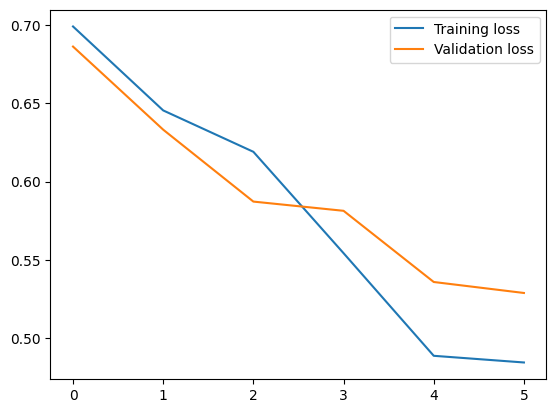

In [33]:
from matplotlib import pyplot as plt
# plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()

In [34]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_dataloader:
        inputs = batch['review'].to(device)
        labels = batch['label'].to(device)
        output = model(inputs)
        predicted = torch.round(output.squeeze())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy: {correct/total}")

Accuracy: 0.76408


Let's repeat the same process but using a LSTM layer instead of a RNN layer.

In [60]:
vocab_size = len(tok2id) + 1 # +1 because we added the padding token
output_size = 1
embedding_dim = 50
hidden_dim = 32
n_layers = 1
device = "mps"

model = SentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, lstm=True)
# model.embedding = embedding_layer
# model.embedding.weight.requires_grad = False # if you want to freeze the embedding layer
model = model.to(device)

/Users/miguelwon/opt/miniconda3/envs/ml-pt-2/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [61]:
# main training loop
n_epochs = 4
lr=1e-3
clip = 1
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

step = 0
evaluation_step = 500
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    loss_train_total = 0
    for i, batch in enumerate(train_dataloader):
        step += 1
        inputs = batch['review'].to(device)
        labels = batch['label'].to(device)

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        output = model(inputs)
        # calculate the loss
        loss = criterion(output.squeeze(), labels.float())
        loss_train_total += loss.item()
        # backward pass
        loss.backward()

        # clip the gradients to prevent exploding gradient problem. This step is very important.
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update the parameters
        optimizer.step()

        # evaluation step
        if step % evaluation_step == 0:
            model.eval()
            with torch.no_grad():
                # evaluate on training data
                loss_val = 0
                for j,batch in enumerate(test_dataloader):
                    inputs = batch['review'].to(device)
                    labels = batch['label'].to(device)

                    output = model(inputs)
                    loss = criterion(output.squeeze(), labels.float())
                    loss_val += loss.item()
            model.train()
            # print the loss at each step 
            print(f'Epochs: {epoch + 1} | Step: {step} | Train Loss: {loss_train_total/i: .3f} | Val Loss: {loss_val/j: .3f}' )
            
            train_losses.append(loss_train_total/i)
            val_losses.append(loss_val/j)
    # print(f'Epochs: {epoch + 1} | Train Loss: {loss_train_total/i: .3f} | Val Loss: {loss_val/j: .3f}' )

Epochs: 1 | Step: 500 | Train Loss:  0.679 | Val Loss:  0.612
Epochs: 2 | Step: 1000 | Train Loss:  0.527 | Val Loss:  0.505
Epochs: 2 | Step: 1500 | Train Loss:  0.488 | Val Loss:  0.429
Epochs: 3 | Step: 2000 | Train Loss:  0.382 | Val Loss:  0.454
Epochs: 4 | Step: 2500 | Train Loss:  0.325 | Val Loss:  0.384
Epochs: 4 | Step: 3000 | Train Loss:  0.320 | Val Loss:  0.413


In [62]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_dataloader:
        inputs = batch['review'].to(device)
        labels = batch['label'].to(device)
        output = model(inputs)
        predicted = torch.round(output.squeeze())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy: {correct/total}")

Accuracy: 0.84332


In [48]:
def predict(text):
    inputs = torch.IntTensor(pad_sequence([tok2id[t] for t in tokenize(text) if t in tok2id])).unsqueeze(0).to(device)
    output = model(inputs)
    predicted = torch.round(output.squeeze()).item()
    if predicted == 1:
        print("Positive review")
    else:
        print("Negative review")

In [51]:
predict("This movie is great!")

Positive review


In [50]:
predict("This movie is so bad!")

Negative review
